In [1]:
import scanpy as sc
import schist
import pandas as pd
%pylab 
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
technology = ['iCELL8', 'Quartzseq', 'MARSseq', '10XV3']

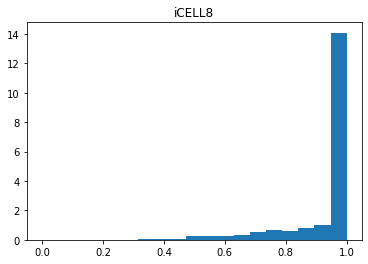

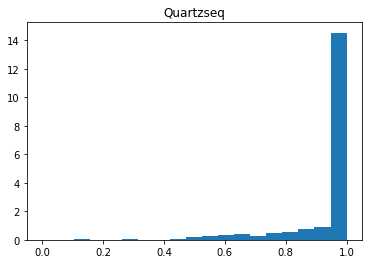

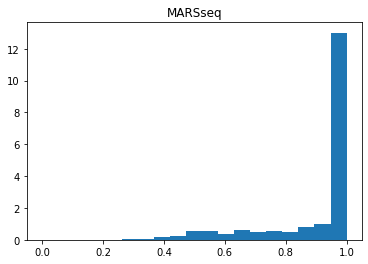

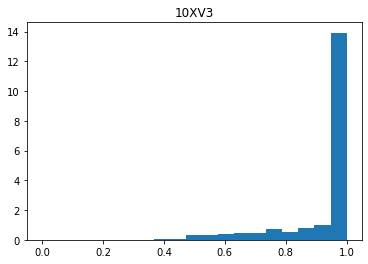

In [3]:
data = dict.fromkeys(technology)
for tech in technology:
    adata = schist.io.read(f'{tech}_073')
    schist.tl.max_marginal(adata)
    figure()
    hist(adata.obs['max_marginal'], bins=np.linspace(0, 1, 20), density=True)
    title(tech)
    data[tech] = adata.copy()
    

In [4]:
for tech in technology:
    thr = .5
    print(tech, data[tech].obs.query('max_marginal < @thr').shape[0] / adata.shape[0])



iCELL8 0.013131976362442548
Quartzseq 0.015101772816808929
MARSseq 0.034143138542350626
10XV3 0.014445173998686802


In [5]:
for tech in technology:
    schist.inference.leiden(data[tech], get_marginals=True)

In [6]:
for tech in technology:
    data[tech].obs['max_leiden_marginal'] = np.max(data[tech].obsm['CM_leiden'], axis=1)

In [7]:
for tech in technology:
    schist.tl.cell_similarity(data[tech])
    schist.tl.cell_stability(data[tech])

They will be recalculated from scratch
They will be recalculated from scratch
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/schist/tools/_affinity_tools.py:190: RuntimeWarning: invalid value encountered in true_divide
  _S = np.array([scipy.stats.entropy(adata.obsm[x], axis=1) /np.log(adata.obsm[x].shape[1]) for x in obsm_names]).T
They will be recalculated from scratch
/Users/cittaro.davide/anaconda3/envs/experimental/lib/python3.8/site-packages/schist/tools/_affinity_tools.py:190: RuntimeWarning: invalid value encountered in true_divide
  _S = np.array([scipy.stats.entropy(adata.obsm[x], axis=1) /np.log(adata.obsm[x].shape[1]) for x in obsm_names]).T
They will be recalculated from scratch


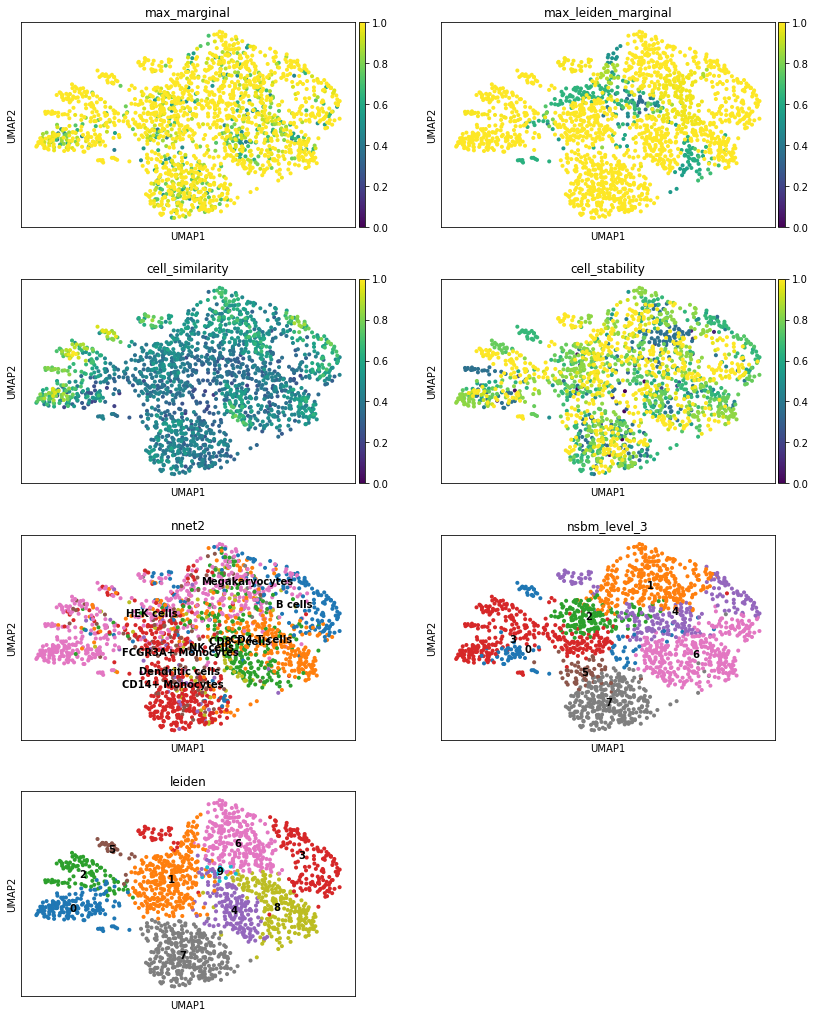

In [25]:
sc.pl.umap(data['iCELL8'], color=['max_marginal', 'max_leiden_marginal',
                                     'cell_similarity', 'cell_stability', 
                                     'nnet2','nsbm_level_3', 'leiden'], 
           ncols=2, vmin=0, vmax=1, legend_loc='on data')

In [26]:
pdata = dict.fromkeys(technology)
for tech in technology:
    pdata[tech] = schist.inference.planted_model(data[tech], n_init=5, copy=True)

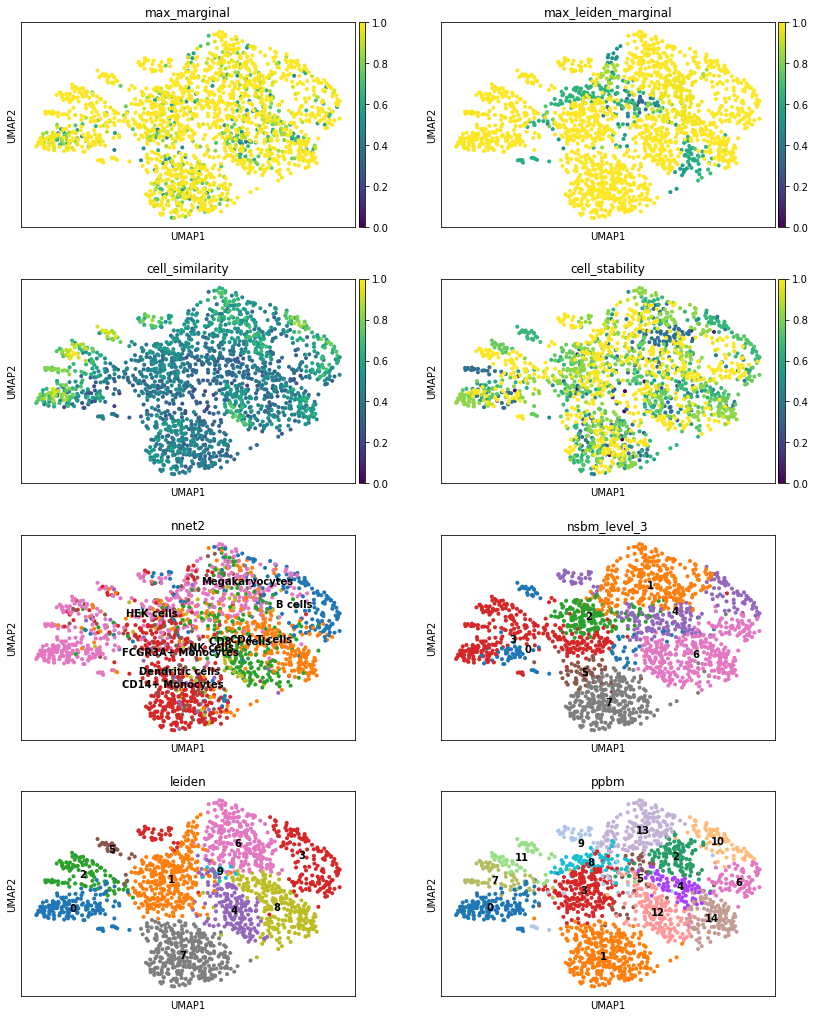

In [27]:
sc.pl.umap(pdata['iCELL8'], color=['max_marginal', 'max_leiden_marginal',
                                     'cell_similarity', 'cell_stability', 
                                     'nnet2','nsbm_level_3', 'leiden', 'ppbm'], 
           ncols=2, vmin=0, vmax=1, legend_loc='on data')

In [31]:
for tech in technology:
    schist.tl.max_marginal(pdata[tech], key_added='ppbm_marginal')

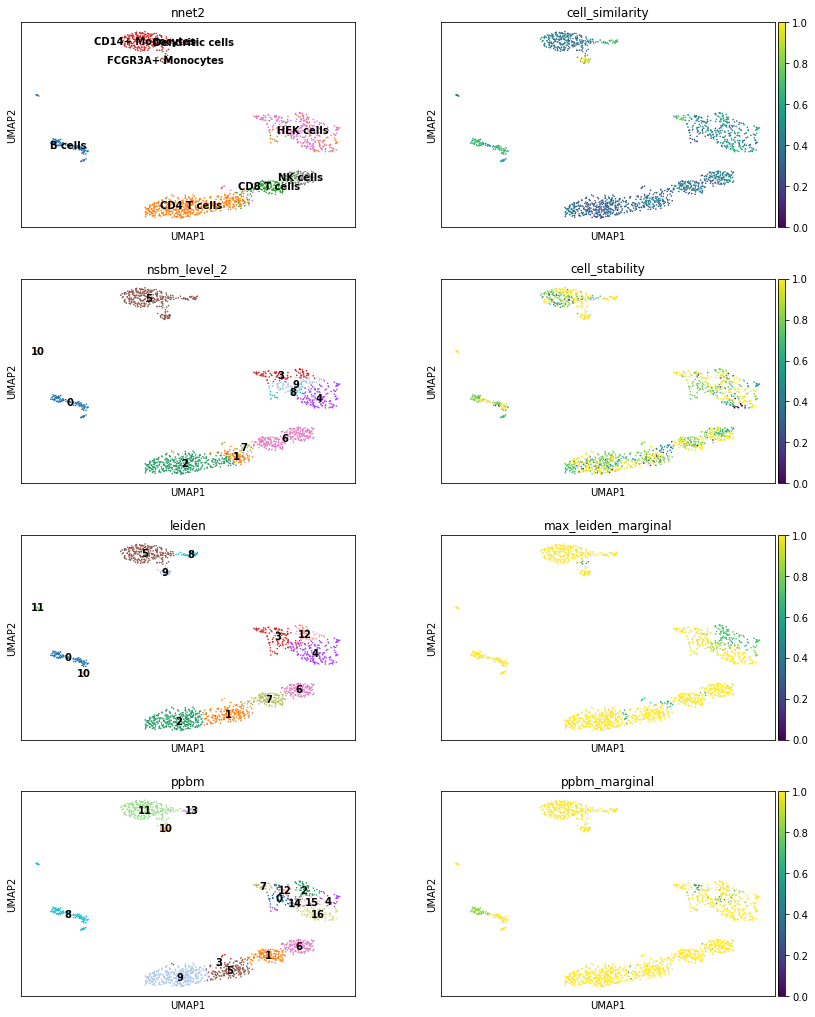

In [37]:
sc.pl.umap(pdata['10XV3'], color=['nnet2', 'cell_similarity',
                                   'nsbm_level_2', 'cell_stability',
                                   'leiden', 'max_leiden_marginal',
                                   'ppbm', 'ppbm_marginal'
                                     ], size=10,
           ncols=2, vmin=0, vmax=1, legend_loc='on data')

In [38]:
import graph_tool.all as gt

In [43]:
[gt.assortativity(pdata[tech].uns['schist']['state'].g, deg='total') for tech in technology]

[(-0.0010395085348526715, 0.0008959611361416015),
 (0.003032225918895701, 0.0019219550002261081),
 (-0.00549055711039324, 0.0009118343984713895),
 (-0.002213076747793402, 0.0012236923407531782)]

In [52]:
for tech in technology:
    g = schist._utils.get_graph_tool_from_adata(pdata[tech], use_weights=True)
    print(gt.assortativity(g, deg='total', eweight=g.ep['weight']))

(0.006017179580515389, 0.0015893163015781005)
(0.023859816387500316, 0.00333094672167084)
(-0.0030084570045986843, 0.0014210731471128322)
(0.008238771447157836, 0.002119036176385166)


In [50]:
schist._utils.get_graph_tool_from_adata(pdata['10XV3']).ep['weight']

<EdgePropertyMap object with value type 'double', for a non-existent graph, at 0x7f9de6723880>

In [66]:
np.random.seed(0)
np.random.choice(range(0, 10000), 100, replace=False)

array([9394,  898, 2398, 5906, 2343, 8225, 5506, 6451, 2670, 3497, 1087,
       1819, 2308, 6084, 3724, 3184, 6387, 3728, 2702, 7883, 2930, 5988,
       4890, 6718, 5423, 3213, 3017,  382, 4237, 4721, 9547, 9477, 4795,
       4747, 9366, 5334, 6652, 9032,  580, 9491, 6526, 4346, 4974, 7913,
       5611, 8480, 6625, 5615, 5602, 4857, 6734, 8451, 6332, 6798, 5313,
       2821, 9300, 2375, 1478, 5013, 1559, 8885, 3986, 4429, 3951, 2932,
       6419,  713, 8089, 6058, 8711, 4185, 4379, 7813,  843,  655, 7219,
        982, 7439, 8894,  598, 5350, 4221, 1422, 3646, 4387, 2606, 4228,
       1096, 8940, 5814, 3706, 2846,  467, 8314, 4595, 3725, 6450, 6846,
       3891])

In [67]:
from joblib import delayed, Parallel

In [68]:
import leidenalg

In [90]:
g = sc._utils.get_igraph_from_adjacency(data['10XV3'].obsp['connectivities'], directed=False)

In [73]:
partition_type = leidenalg.RBConfigurationVertexPartition

In [91]:
partition_kwargs = {}
partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
partition_kwargs['n_iterations'] = -1
np.random.seed(0)
samples = 100
seeds = np.random.choice(range(0, samples**2), size=samples, replace=False)
partition_kwargs['resolution_parameter'] = 1


In [92]:
parts = [leidenalg.find_partition(g, partition_type, seed=seeds[x],
                                       **partition_kwargs).membership for x in range(samples)]

In [94]:
def lpart(g, partition_type, seed, **partition_kwargs):
    return leidenalg.find_partition(g, partition_type, seed=seed, **partition_kwargs).membership

In [103]:
ppart = Parallel(n_jobs=4)(delayed(lpart)(g, partition_type, seeds[i], **partition_kwargs) for i in range(samples))

In [107]:
np.array(parts[12])

array([7, 2, 0, ..., 8, 0, 0])

In [108]:
np.array(ppart[12])

array([7, 2, 0, ..., 8, 0, 0])